# Кластеризация 
## Дзюба Мария, 214 группа 

## Собственная реализация Kmeans 

In [159]:
import numpy as np
from pandas import *
import matplotlib.pyplot as plt

In [160]:
def closest(dot, centers):                                       # Функция для определения ближайшего центра к заданной точке
    distance = []
    for center in centers:
        cur_length = 0

        for i in range(len(dot)):
            cur_length += (center[i] - dot[i]) ** 2
        distance.append(cur_length)
    return np.argmin(distance)

In [161]:
def new_center(dots_in_cluster):
    new_coordinate = []
    coordinate = np.zeros(len(dots_in_cluster[0]))
    for i in range(coordinate.shape[0]):
        for elem in dots_in_cluster:
            coordinate[i] += elem[i]
        new_coordinate += [coordinate[i] / len(dots_in_cluster)]
    return new_coordinate

In [162]:
class Kmeans:                                                   # Класс Kmeans
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def initial_centers(self, num, matrix):
        np.random.shuffle(matrix)
        y = DataFrame(matrix).drop_duplicates().values
        if self.n_clusters > len(y):      # если количество различных элементов в исходных данных меньше, чем n_clusters
            self.n_clusters = len(y)      # то мы уменьшаем число кластеров
        centers = y[:self.n_clusters]
        return centers
    
    def fit(self, matrix):
        self.matrix = matrix
        centers = self.initial_centers(self.n_clusters, self.matrix)
        self.initial_c = centers
        count = 0
        while True:
            clusters = []
            for i in range(self.n_clusters):
                clusters.append([])

            for dot in matrix:
                clusters[closest(dot, centers)].append(dot)

            new_centers = []
            for cluster in clusters:
                new_centers += [new_center(cluster)]

            check = True                                    # check == True, если новые центры совпадают со старыми
            for ind in range(len(centers)):
                for i in range(matrix.shape[1]):
                    check = check and (new_centers[ind][i] == centers[ind][i])   # проверяем на совпадение

            if not check:
                centers = np.array([elem for elem in new_centers])
            else:
                self.centers = centers
                break
        return centers

    def predict(self, x):
        labels = []
        for dot in x:
            labels += [closest(dot, self.centers)]
        return labels

## Зависимость от стратегии начальной инициализации 

##### В коде выше я использовала случайную инициализацию центров, что не всегда является оптимальным решением. В своей реализации kmeans я исключаю вариант повторения центров.

### Реализация Kmeans++

In [163]:
def furthest(possible_centers, found_centers):                          # Функция для определения наиболее далеких точек
    distance = []
    for dot in possible_centers:
        cur_distance = 0
        for elem in found_centers:
            for i in range(len(dot)):
                cur_distance += (dot[i] - elem[i])**2
        distance.append(cur_distance)
    return np.argmax(distance)

In [164]:
class Kmeans_plus:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        
    def initial_centers(self, num, matrix):
        np.random.shuffle(matrix)
        y = DataFrame(matrix).drop_duplicates().values
        if self.n_clusters > len(y):      # если количество различных элементов в исходных данных меньше, чем n_clusters
            self.n_clusters = len(y)      # то мы уменьшаем число кластеров           
        centers = [y[0]]  # рандомная первая точка
        next_max = 0
        while len(centers) != self.n_clusters:
            y = np.delete(y, next_max, 0)
            next_max = furthest(y, centers)
            centers += [y[next_max]]
        return centers
    
    
    def fit(self, matrix):
        self.matrix = matrix
        centers = self.initial_centers(self.n_clusters, self.matrix)
        self.initial_c = centers
        count = 0
        while True:
            clusters = []
            for i in range(self.n_clusters):
                clusters.append([])

            for dot in matrix:
                clusters[closest(dot, centers)].append(dot)

            new_centers = []
            for cluster in clusters:
                new_centers += [new_center(cluster)]

            check = True                                    # check == True, если новые центры совпадают со старыми
            
            for ind in range(len(centers)):
                for i in range(matrix.shape[1]):
                    check = check and (new_centers[ind][i] == centers[ind][i])   # проверяем на совпадение

            if not check:
                centers = np.array([elem for elem in new_centers])
            else:
                self.centers = centers
                break
        return centers

    def predict(self, x):
        labels = []
        for dot in x:
            labels += [closest(dot, self.centers)]
        return labels   

##### Сравним работы kmeans и kmeans++ на примере обработки фотографии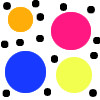

In [165]:
from PIL import Image
image = Image.open('C:\circles2.jpg')
width = image.size[0]
height = image.size[1]
pix = image.load()

data = []
pix_data = []
for x in range(width):
    for y in range(height):
        r = pix[x, y][0]  # красный
        g = pix[x, y][1]  # зеленый
        b = pix[x, y][2]  # синий
        data += [[r, g, b]]
        pix_data += [[y, x]]

pix_data = np.array(pix_data)

X = np.array(data)
X1 = np.array(data)

##### Как kmeans, так и kmeans++ очень сильно зависят от начальной инициализации ( в случае kmeans++ от первого, случайно взятого центра ). Если мы запустим данный алгоритм несколько раз подряд, мы можем понять, что kmeans++ больше подходит для обработки контрастных изображений, потому что близкие по оттенку цвета в большинстве случаев сливаются в один.

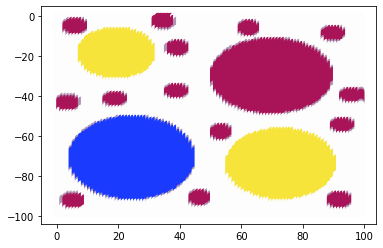

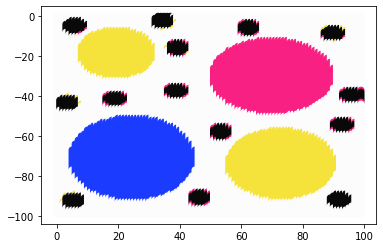

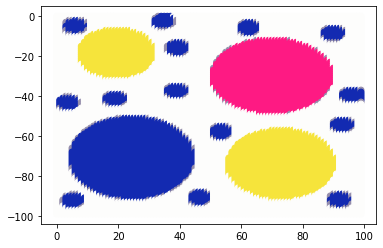

In [166]:
for j in range(3):
    a = Kmeans(n_clusters=5)
    centers = a.fit(X)
    labels = a.predict(X1)
    labels_col = [(centers[elem]/255) for elem in labels]
    plt.scatter(pix_data[:, 1], -pix_data[:, 0], c=labels_col)
    plt.show()

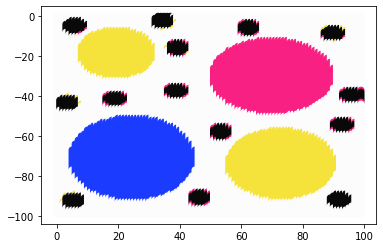

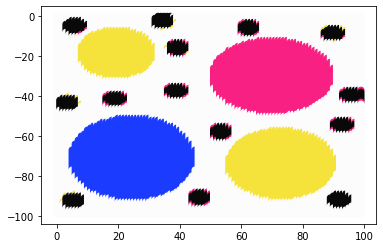

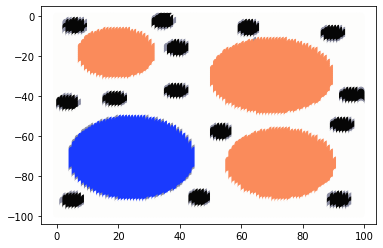

In [167]:
for j in range (3):
    a = Kmeans_plus(n_clusters=5)
    centers = a.fit(X)
    labels = a.predict(X1)
    labels_col = [(centers[elem]/255) for elem in labels]
    plt.scatter(pix_data[:, 1], -pix_data[:, 0], c=labels_col)
    plt.show()

##### При работе с изображениями kmeans++ выделяет контрастные области, чаще всего без чувствительности к оттенкам (но это зависит от случайно выбранной первой точки, как на примере внизу) 

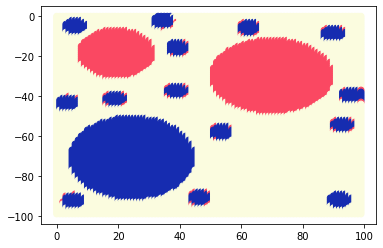

In [171]:
a = Kmeans_plus(n_clusters=3)
centers = a.fit(X)
labels = a.predict(X1)
labels_col = [(centers[elem]/255) for elem in labels]
plt.scatter(pix_data[:, 1], -pix_data[:, 0], c=labels_col)
plt.show()

##### Рассмотрим кластеризацию искуственно заданных данных, и сравним ее, в зависимости от метода kmeans или kmeans++:

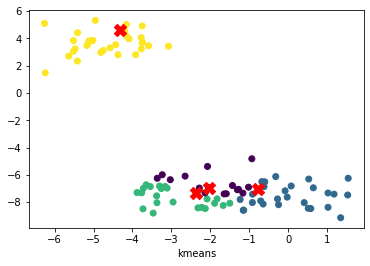

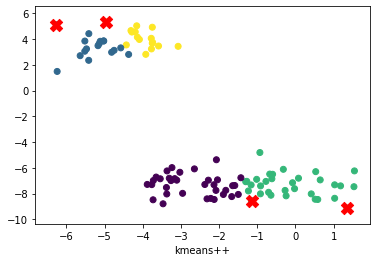

In [153]:
from sklearn.datasets.samples_generator import make_blobs
from pandas import DataFrame

a = Kmeans(n_clusters=4)
b = Kmeans_plus(n_clusters=4)
X, y = make_blobs(n_samples=100, centers=3)

centers_a = a.fit(X)
labels_a = a.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels_a)
plt.scatter(np.array(a.initial_c)[:,0],np.array(a.initial_c)[:,1],s=150, c='red', marker = 'X')
plt.xlabel('kmeans')
plt.show()

centers_b = b.fit(X)

labels_b = b.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels_b)
plt.scatter(np.array(b.initial_c)[:,0],np.array(b.initial_c)[:,1],s=150, c='red', marker = 'X' )
plt.xlabel('kmeans++')
plt.show()


###### Как мы можем заметить, при использовании kmeans, кластеризация имеет большую погрешность (из-за произвольного выбора начальных центров). Однако, стоит так же помнить, что при большом количестве кластеров, алгоритм kmeans++ будет выполняться значительно дольше.

## Применение kmeans и kmeans ++

### Классификация изображений по цвету

##### Программа ниже обучается на фотографии розы и фотографии лилии и анализирует, что изображено на третьей фотографии (относительно цвета)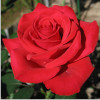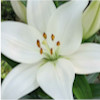

In [172]:
image = Image.open('C:\lilia.jpg')
width = image.size[0]
height = image.size[1]
pix = image.load()

data_l = []
for x in range(width):
    for y in range(height):
        r = pix[x, y][0]  # красный
        g = pix[x, y][1]  # зеленый
        b = pix[x, y][2]  # синий
        data_l += [[r, g, b]]


image = Image.open("C:/rose.jpg")
width = image.size[0]
height = image.size[1]
pix = image.load()
data_r = []
for x in range(width):
    for y in range(height):
        r = pix[x, y][0]  # красный
        g = pix[x, y][1]  # зеленый
        b = pix[x, y][2]  # синий
        data_r += [[r, g, b]]
XL = np.array(data_l)
XR = np.array(data_r)
a = Kmeans(n_clusters=2)
centers = a.fit(XL)
centers = np.append(centers, a.fit(XR), axis=0)    # получаем многомерный массив, в котором первые два кластера соответсвуют 
                                                   # лилии, вторые - розе 

##### lilia3.jpg 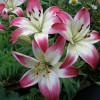

In [155]:
image = Image.open("C:/lilia3.jpg")
width = image.size[0]
height = image.size[1]
pix = image.load()
data_smth2 = []
pix_data2 = []
for x in range(width):
    for y in range(height):
        r = pix[x, y][0]  # красный
        g = pix[x, y][1]  # зеленый
        b = pix[x, y][2]  # синий
        data_smth2 += [[r, g, b]] 
        pix_data2 += [[y, x]]

pix_data2 = np.array(pix_data)

In [156]:
lilia_c = 0
rose_c = 0
XSMTH2 = np.array(data_smth2)
labels_2 = a.predict(XSMTH2)
for elem in labels_2:
    if elem == 1 or elem == 0:
        lilia_c += 1
    else:
        rose_c += 1
if lilia_c > rose_c:
    print("Это лилия!")

Это лилия!


### Сжатие картинки (уменьшением количества цветов) 

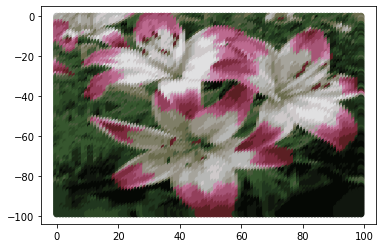

In [157]:
image = Image.open('C:\lilia3.jpg')
width = image.size[0]
height = image.size[1]
pix = image.load()

data = []
pix_data = []
for x in range(width):
    for y in range(height):
        r = pix[x, y][0]  # красный
        g = pix[x, y][1]  # зеленый
        b = pix[x, y][2]  # синий
        data += [[r, g, b]]
        pix_data += [[y, x]]

pix_data = np.array(pix_data)

X = np.array(data)
X1 = np.array(data)

a = Kmeans_plus(n_clusters=20)
centers = a.fit(X)
labels = a.predict(X1)
labels_col = [(centers[elem]/255) for elem in labels]
plt.scatter(pix_data[:, 1], -pix_data[:, 0], c=labels_col)
plt.show()

## Зависимость скорости обучения от объема данных

##### Как мы видим, зависимость от объема данных линейная 

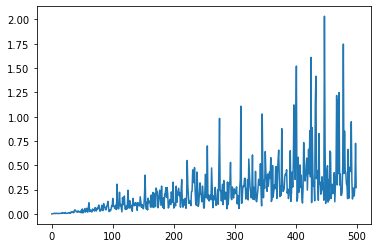

In [16]:
import time
intervals = []
for j in range(500):
    a = Kmeans(n_clusters=4)
    X, y = make_blobs(n_samples=5 * j, centers=4, cluster_std = 1, n_features=2,)
    start = time.time()
    centers = a.fit(X)
    finish = time.time() - start
    intervals += [finish]
plt.plot(intervals)
plt.show()

## Зависимость скорости обучения от выбора начального метода

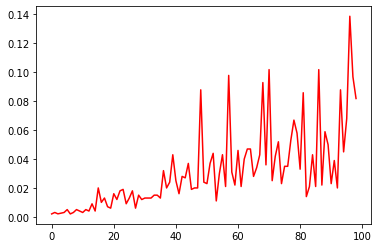

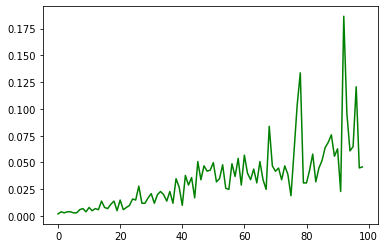

In [17]:
import time
intervals_a = []
intervals_b = []
for j in range(1,100):
    a = Kmeans(n_clusters=4)
    X, y = make_blobs(n_samples=5 * j, centers=4, cluster_std = 1, n_features=2,)
    start = time.time()
    centers = a.fit(X)
    finish = time.time() - start
    intervals_a += [finish]
    
    b = Kmeans_plus(n_clusters=4)
    X, y = make_blobs(n_samples=5 * j, centers=4, cluster_std = 1, n_features=2,)
    start = time.time()
    centers = b.fit(X)
    finish = time.time() - start
    intervals_b += [finish]
    
plt.plot(intervals_a, c='red')
plt.show()
plt.plot(intervals_b, c='green')
plt.show()

##### Как мы видим, среднее время выполнения Kmeans++ больше, чем Kmeans. Этот фактор надо учитывать при выборе испульзуемого метода:

In [18]:
mean_a = sum(intervals_a)/len(intervals_a)
print('Среднее время выполнения методом Kmeans: ', mean_a)
mean_b = sum(intervals_b)/len(intervals_b)
print('Среднее время выполнения методом Kmeans++: ',mean_b)

Среднее время выполнения методом Kmeans:  0.031175777165576665
Среднее время выполнения методом Kmeans++:  0.03464457964656329


## Зависимость скорости обучения от сложности данных

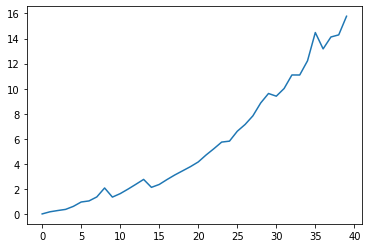

In [54]:
intervals = []
for i in range(1, 200, 5):
    X, y = make_blobs(n_samples=250, centers=3, n_features=i)
    a = Kmeans(n_clusters=i)
    t1 = time.time()
    a.fit(X)
    intervals.append(time.time() - t1)

plt.plot(intervals)
plt.show()

## Стратегия выбора числа кластеров

##### Одним из недостатков метода k-means является неявная стратегия выбора числа кластеров. Именно поэтому, в некоторых случаях вместо метода k-means используют метод g-means, в основу работы которого входит алгоритм k-means.

## Визуализация матрицы попарных расстояний

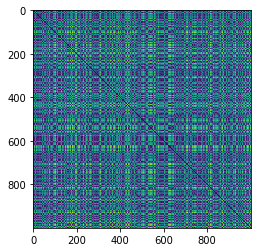

In [129]:
from scipy.spatial import distance_matrix
X, y = make_blobs(n_samples=1000, centers=7, n_features=2, random_state=1)
dist_m = distance_matrix(X,X)
plt.imshow(dist_m)
plt.show()

##### Если мы составим матрицу попарных расстояний, основываясь на нашей кластеризации, выводя точки в порядке кластеров, то мы получим:

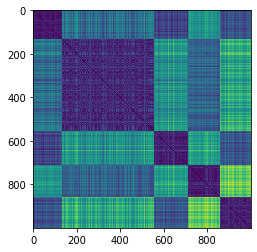

In [133]:
X1 = X.copy()

New_seq = []
a = Kmeans_plus(n_clusters=5)
centers = a.fit(X)
labels = a.predict(X1)
for i in range(len(centers)):
    for j in range(len(labels)):
        if labels[j] == i:
            New_seq.append(X1[j])

New_x = np.array(New_seq)
dist_m1 = distance_matrix(New_x, New_x)
plt.imshow(dist_m1)
plt.show()

##### Если мы будем создавать новую матрицу, изначально расположив кластеры в порядке уменьшения количества принадлежащих им элементов, то наша матрица будет иметь вид:


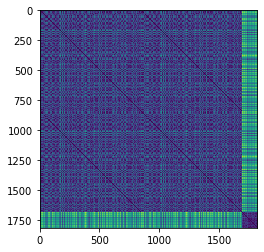

In [134]:
New = []

amount_of_dots_in_cluster = np.zeros(len(centers))
for i in range(len(labels)):
    amount_of_dots_in_cluster[labels[i]] += 1

while len(amount_of_dots_in_cluster) != 0:
    ind = np.argmax(amount_of_dots_in_cluster)
    amount_of_dots_in_cluster = np.delete(amount_of_dots_in_cluster, ind, 0)
    for j in range(len(labels)):
        if labels[j] == ind:
            New.append(X1[j])

New = np.array(New)

dist_m1 = distance_matrix(New, New)
plt.imshow(dist_m1)
plt.show()

#####  Если мы будем создавать новую матрицу, изначально расположив кластеры в порядке уменьшения длины их центров, то наша матрица будет иметь вид:

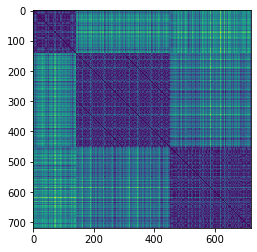

In [136]:
New = []
length_of_centre = np.zeros(len(centers))
c_ind = 0
for center in centers:
    for i in range(len(center)):
        length_of_centre[c_ind] += center[i]**2
    c_ind += 1

while len(length_of_centre) != 0:
    ind = np.argmax(length_of_centre)
    length_of_centre = np.delete(length_of_centre, ind, 0)
    for j in range(len(labels)):
        if labels[j] == ind:
            New.append(X1[j])

New = np.array(New)
dist_m1 = distance_matrix(New, New)
plt.imshow(dist_m1)
plt.show()